In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [3]:
def adjusted_rta(values, vehicle_kw, keys = []):

    rta = src.routing.road_trip_accessibility(values)

    end_soc = src.routing.road_trip_accessibility(
        values, field = 'soc', keys = keys,
    )

    excess_chg_time = (end_soc - .1) * vehicle_kw['capacity'] / vehicle_kw['charge_rate']

    return (rta - excess_chg_time) / 3600

In [5]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

cities = [k for k, v in graph._node.items() if v['type'] == 'city']

In [6]:
deep_reload(src)
import re

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'charge_rate': lambda x: x[1]['charge_rate'] / 1e3,
    'risk_attitude': lambda x: (x[1]['risk_attitude'][0] + x[1]['risk_attitude'][1]) / 2,
    'arrival_ratio': lambda x: x[2]['arrival_param'][0],
    'reliability': lambda x: x[2]['reliability'],
    'graph_index': lambda x: x[0],
    'rta': lambda x: src.routing.road_trip_accessibility(x[4], keys = cities) / 3600,
    'rta_adj': lambda x: adjusted_rta(x[4], out[1], keys = cities),
}

paths = {}

outputs = {k: [] for k in functions.keys()}

idx = 0

for file in src.progress_bar.ProgressBar(files):

    idx = eval(re.findall(r'\d+', file)[0])

    if idx < 2000:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

        paths[idx] = out[5]

    for key, fun in functions.items():

        outputs[key].append(fun(out))

 [------->] (3030/3030) 100.00%, 340.46 it/s, 8.90 s elapsed, 0.00 s remaining

In [7]:
outputs_norm = outputs.copy()

keys = ['capacity', 'charge_rate', 'risk_attitude', 'reliability', 'arrival_ratio']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [8]:
df

,capacity,charge_rate,risk_attitude,arrival_ratio,reliability,graph_index,rta,rta_adj
0,0.142158,0.110333,0.586118,0.650217,0.278036,1,7.772137,8.167638
1,0.267303,0.137519,0.112176,0.006421,0.104064,2,6.265143,6.061290
2,0.620796,0.021404,0.389144,0.975054,0.826794,1,6.566200,6.215140
3,0.774818,0.272151,0.057096,0.820635,0.084264,1,6.248704,5.914802
4,0.137635,0.121176,0.685023,0.490905,0.957797,1,7.125516,7.197921
...,...,...,...,...,...,...,...,...
1495,0.792774,0.883252,0.440655,0.341551,0.974923,2,5.759698,5.574577
1496,0.727708,0.502330,0.234034,0.728689,0.577266,1,6.026794,5.793301
1497,0.077231,0.996860,0.342959,0.264676,0.931302,2,6.514839,6.460551
1498,0.213773,0.332643,0.225548,0.549331,0.569347,1,6.742789,6.670645


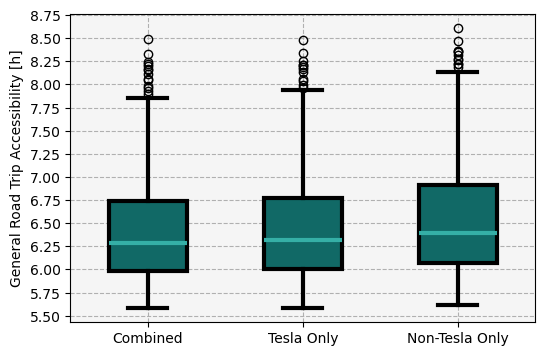

In [50]:
x = [
    df[df['graph_index'] == 0]['rta'],
    df[df['graph_index'] == 1]['rta'],
    df[df['graph_index'] == 2]['rta'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#116966',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#35afa6',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'General Road Trip Accessibility [h]',
    'yticks': np.arange(5.5, 9, .25),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

fig.savefig('Paper/figs/Networks_Boxplots.png', bbox_inches = 'tight', dpi = 300)

In [143]:
# df_sel = df[(df['graph_index'] == 0)]
df_sel = df

formula = (
    'rta ~ ' +
    'graph_index * ' + 
    'capacity * ' + 
    'charge_rate * ' + 
    'reliability * ' +
    'arrival_ratio * ' +
    'risk_attitude'
)

formula = (
    'rta ~ ' +
    'C(graph_index) + ' + 
    'capacity + ' + 
    'charge_rate + ' + 
    'reliability + ' +
    'arrival_ratio + ' +
    'risk_attitude'
)

model = smf.ols(formula, data = df_sel).fit()

In [144]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rta   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1222.
Date:                Wed, 22 May 2024   Prob (F-statistic):               0.00
Time:                        20:48:21   Log-Likelihood:                 218.24
No. Observations:                 987   AIC:                            -420.5
Df Residuals:                     979   BIC:                            -381.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.9527      0.025    283.072      0.000       6.905       7.001
C(graph_index)[T.1]     0.0240      0.015      1.583      0.114      -0.006       0.054
C(graph_index)[T.2]     0.1166      0.015      7.670      0.000       0.087       0.146
capacity               -1.5445      0.021    -74.144      0.000      -1.585      -1.504
charge_rate            -0.3869      0.021    -18.095      0.000      -0.429      -0.345
reliability            -0.5870      0.021    -27.658      0.000      -0.629      -0.545
arrival_ratio           0.8297      0.022     37.945      0.000       0.787       0.873
risk_attitude           0.7101      0.022     32.851      0.000       0.668       0.753
==============================================================================
Omnibus:                       46.737   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.642
Skew:                           0.219   Prob(JB):                     2.85e-26
Kurtosis:                       4.634   Cond. No.                         8.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.significant_parameters_tabular(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

print(out_string)

\hline {\small Intercept } & 6.953 & 0.000 \\
\hline {\small capacity } & -1.545 & 0.000 \\
\hline {\small charge_rate } & -0.387 & 0.000 \\
\hline {\small reliability } & -0.587 & 0.000 \\
\hline {\small arrival_ratio } & 0.830 & 0.000 \\
\hline {\small risk_attitude } & 0.710 & 0.000 \\
\hline {\small Non-Tesla Only } & 0.117 & 0.000 \\



In [146]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df, 'rta', 4, c = 3,
)

print(out_string)

4 48
939 47 986
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.947 & 0.897 & 0.892 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 324.468 & 47 & 6.904 \\
\hline Error & 37.135 & 939 & 0.040 \\
\hline Total & 361.604 & 986 & 0.367 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{174.563} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None


In [156]:
stations_used = {}

for idx, path_collection in paths.items():
    # print(path_collection)

    for path_col in path_collection.values():

        for path in path_col.values():
            # print(path)

            for p in path:

                # print(p)

                if p in stations_used:

                    stations_used[p] += 1

                else:

                    stations_used[p] = 1
    #             print(p)
    #             break
    #         break
    #     break
    # break

In [158]:
len(stations_used)

352

In [211]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')
nodes = graph._node

In [175]:
nodes = graph._node

utilization = [v for k, v in stations_used.items() if 'station' in k]
ris = [nodes[k]['n_dcfc'] for k, v in stations_used.items() if 'station' in k]
ris_gen = [n['n_dcfc'] for k, n in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]
# exp_delay = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

In [246]:
un, unc = np.unique(network, return_counts = True)
indices = np.argsort(unc)

un = un[indices]
unc = unc[indices]

x = np.array(list(range(len(unc))))

In [247]:
networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
ung, ungc = np.unique(networks_general, return_counts = True)
indices = [np.argwhere(ung == n) for n in un]
indices = np.array([idx[0][0] for idx in indices if idx])
indices

ung = ung[indices]
ungc = ungc[indices]

# x = list(range(len(unc)))

In [248]:
ung, un

(array(['Blink Network', 'EVRANGE', 'EVGATEWAY', 'CIRCLE_K',
        'ChargePoint Network', 'SHELL_RECHARGE', 'EV Connect', 'EVCS',
        'Non-Networked', 'Electrify America', 'eVgo Network', 'Tesla'],
       dtype='<U19'),
 array(['Blink Network', 'EVRANGE', 'EVGATEWAY', 'CIRCLE_K',
        'ChargePoint Network', 'SHELL_RECHARGE', 'EV Connect', 'EVCS',
        'Non-Networked', 'Electrify America', 'eVgo Network', 'Tesla'],
       dtype='<U19'))

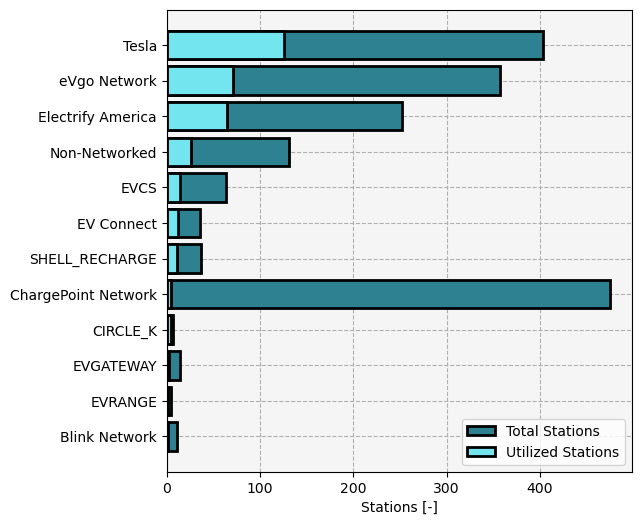

In [255]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Stations'
}

ax.barh(x, ungc, **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, unc, **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': un,
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

_ = ax.legend()

In [188]:
from scipy.stats import rv_histogram

x = list(range(1, 71))

h_u = rv_histogram(np.histogram(ris, bins = x))
h_g = rv_histogram(np.histogram(ris_gen, bins = x))

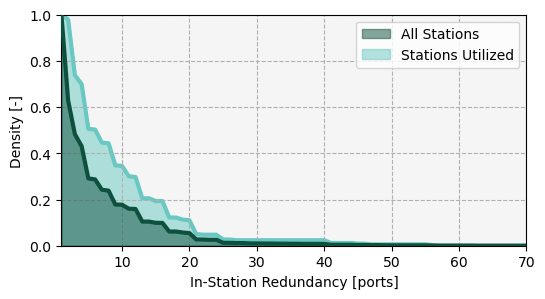

In [189]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_g.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'All Stations',
}

ax.fill_between(x, 0, h_g.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_u.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Stations Utilized'
}

ax.fill_between(x, 0, h_u.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'In-Station Redundancy [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

# fig.savefig('Paper/figs/California_RIS_Hist.png', bbox_inches = 'tight', dpi = 300)